In [418]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pandas_datareader as web
import datetime as dt
import yfinance as yf

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.layers import GRU

Download Tesla stock data from Yahoo Finance

In [419]:
start = dt.datetime(2020, 1, 1)
start = dt.datetime(2024,1 , 1)
end = dt.datetime.now()
tesla_data = yf.download('TSLA', start=start, end=end)
tesla_data

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2024-01-02,248.419998,248.419998,251.250000,244.410004,250.080002,104654200
2024-01-03,238.449997,238.449997,245.679993,236.320007,244.979996,121082600
2024-01-04,237.929993,237.929993,242.699997,237.729996,239.250000,102629300
2024-01-05,237.490005,237.490005,240.119995,234.899994,236.860001,92379400
2024-01-08,240.449997,240.449997,241.250000,235.300003,236.139999,85166600
...,...,...,...,...,...,...
2024-12-05,369.489990,369.489990,375.429993,359.500000,359.869995,81403600
2024-12-06,389.220001,389.220001,389.489990,370.799988,377.420013,81455800


data exploration 

In [420]:
tesla_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2024-01-02,248.419998,248.419998,251.250000,244.410004,250.080002,104654200
2024-01-03,238.449997,238.449997,245.679993,236.320007,244.979996,121082600
2024-01-04,237.929993,237.929993,242.699997,237.729996,239.250000,102629300
2024-01-05,237.490005,237.490005,240.119995,234.899994,236.860001,92379400
2024-01-08,240.449997,240.449997,241.250000,235.300003,236.139999,85166600


In [421]:
tesla_data.shape

(239, 6)

In [422]:
tesla_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 239 entries, 2024-01-02 to 2024-12-11
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, TSLA)  239 non-null    float64
 1   (Close, TSLA)      239 non-null    float64
 2   (High, TSLA)       239 non-null    float64
 3   (Low, TSLA)        239 non-null    float64
 4   (Open, TSLA)       239 non-null    float64
 5   (Volume, TSLA)     239 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.1 KB


In [423]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)


In [424]:
prices = tesla_data['Close'].values
prices = prices.reshape(-1, 1)


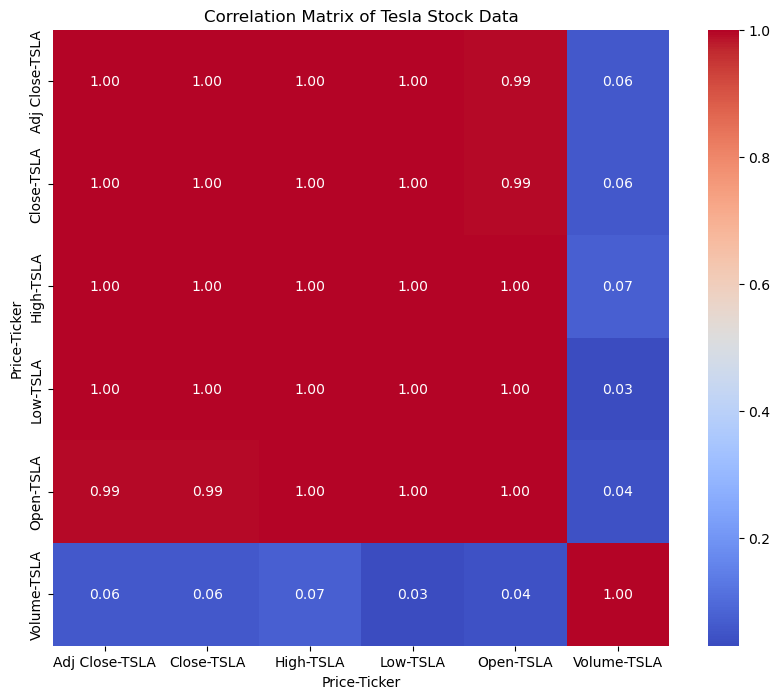

In [425]:
correlation_matrix = tesla_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of Tesla Stock Data')
plt.show()

Plot the closing prices of Tesla stock over time

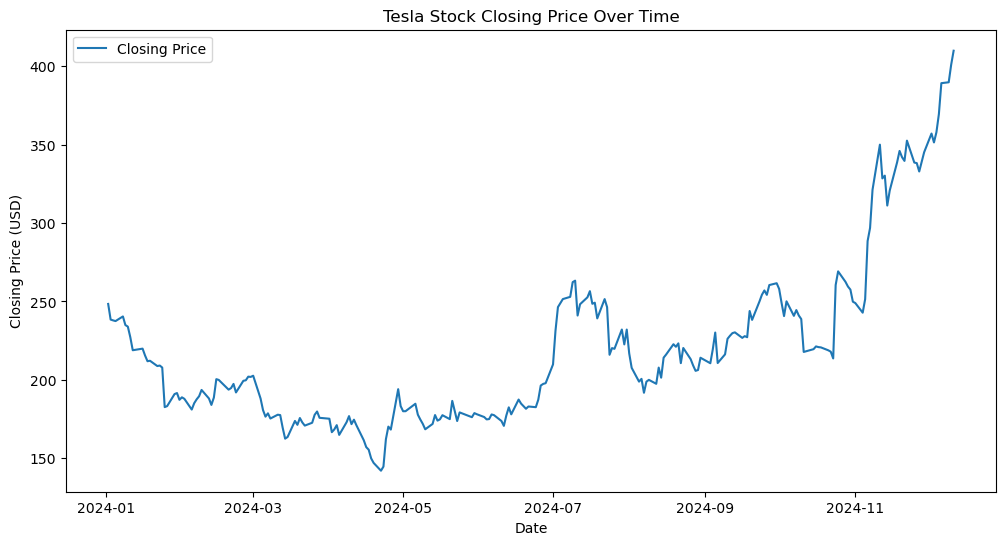

In [426]:
plt.figure(figsize=(12, 6))
plt.plot(tesla_data['Close'], label='Closing Price')
plt.title('Tesla Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()


boxplot to show the distribution of stock prices and detect outliers

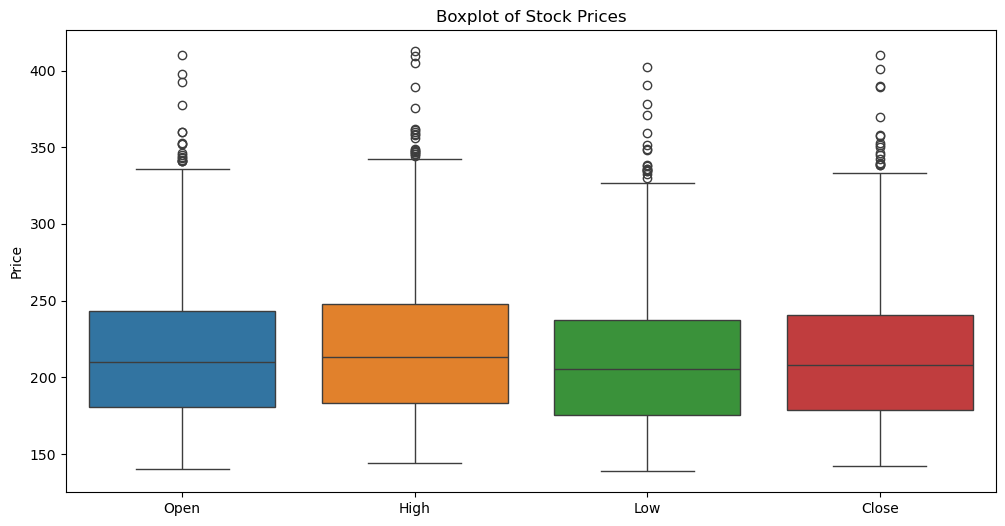

In [427]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=tesla_data[['Open', 'High', 'Low', 'Close']])
plt.title('Boxplot of Stock Prices')
plt.ylabel('Price')
plt.show()

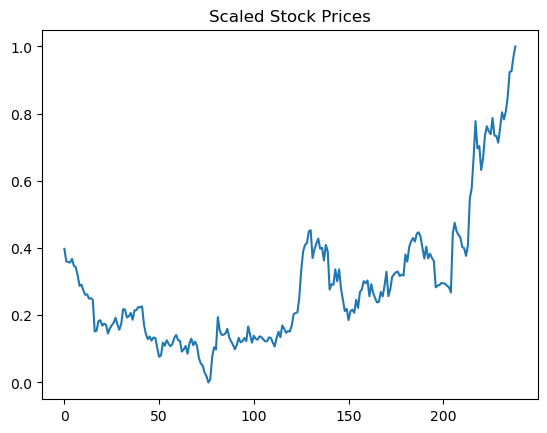

In [428]:
plt.plot(scaled_prices)
plt.title("Scaled Stock Prices")
plt.show()

In [429]:
tesla_data.isnull().sum()


Price      Ticker
Adj Close  TSLA      0
Close      TSLA      0
High       TSLA      0
Low        TSLA      0
Open       TSLA      0
Volume     TSLA      0
dtype: int64

In [430]:
print(scaled_prices.shape)  # This should give you something like (1510, 1)


(239, 1)


 number of days for predicting future prices

In [431]:
time_steps = 50
X, y = create_dataset(scaled_prices, time_steps)

train_size = int(len(X) * 0.8)  
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (151, 50, 1), y_train shape: (151, 1)
X_test shape: (38, 50, 1), y_test shape: (38, 1)


In [432]:

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),  
    LSTM(50, return_sequences=False),  
    Dense(25, activation='relu'),      
    Dense(1)                          
])

model.compile(optimizer='adam', loss='mean_squared_error')


model.summary()


c:\Users\micha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 50, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - loss: 0.0535 - val_loss: 0.2235
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0148 - val_loss: 0.0227
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0106 - val_loss: 0.0865
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0061 - val_loss: 0.0878
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0066 - val_loss: 0.0368
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0059 - val_loss: 0.0530
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0053 - val_loss: 0.0582
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0048 - val_loss: 0.0365
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0043 - val_loss: 0.0356
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0039 - val_loss: 0.0355
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0036 - val_loss: 0.0288
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0040 - val_loss: 0.0242


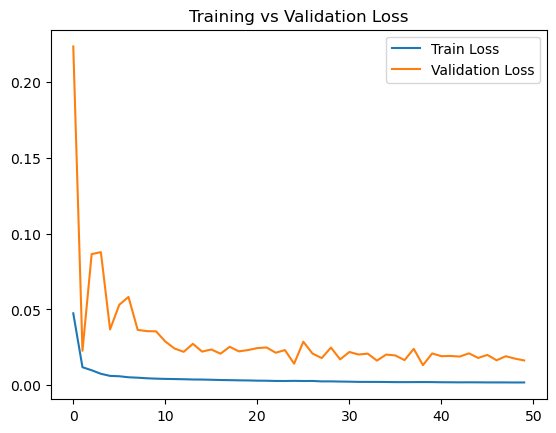

In [433]:

history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


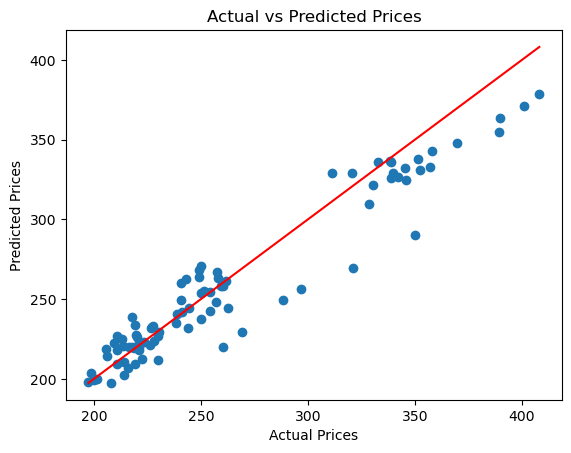

In [434]:
plt.scatter(actual_prices, predicted_prices)
plt.plot([min(actual_prices), max(actual_prices)], [min(actual_prices), max(actual_prices)], color='red')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()

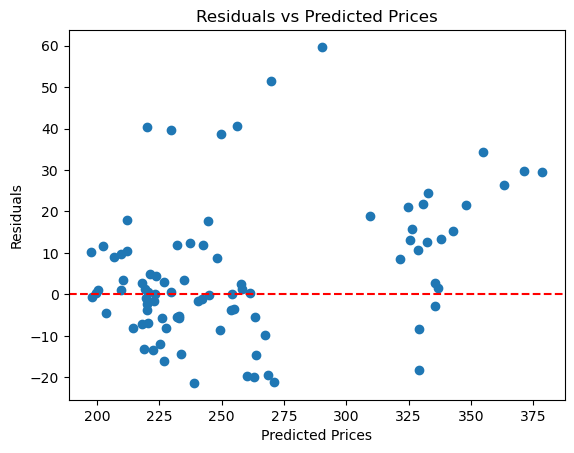

In [435]:
residuals = actual_prices - predicted_prices
plt.scatter(predicted_prices, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Prices')
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step


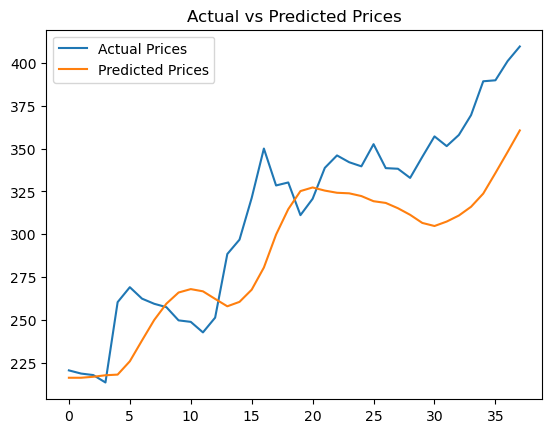

In [436]:

predictions = model.predict(X_test)

predicted_prices = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.plot(actual_prices, label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.legend()
plt.title("Actual vs Predicted Prices")
plt.show()


In [437]:
print(f"Actual prices shape: {actual_prices.shape}")
print(f"Predicted prices shape: {predicted_prices.shape}")


Actual prices shape: (38, 1)
Predicted prices shape: (38, 1)


In [438]:
mae = mean_absolute_error(actual_prices.flatten(), predicted_prices.flatten())


In [444]:
mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 28.49785493549548
Root Mean Squared Error (RMSE): 34.15154753205698


 Plot the actual prices vs predicted prices

In [445]:

model.save('tesla_stock_price_prediction_model.keras')
print("stock_price_prediction_model.keras")


stock_price_prediction_model.keras


In [446]:
last_sequence = scaled_prices[-time_steps:]
last_sequence = last_sequence.reshape(1, time_steps, 1)
next_price_scaled = model.predict(last_sequence)
next_price = scaler.inverse_transform(next_price_scaled)
print(f"Predicted Next Day Price: {next_price[0][0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Next Day Price: 371.76953125
